In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from IPython.display import clear_output

# core MAGI-TFP class
import magi_v2

/Users/skylerwu/Desktop/JASA/for_professor_yang/magi_v2.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# 4-component model governing the SEIR system, appropriate for tensorflow vectorization
def f_vec(t, X, thetas):
    '''
    1. X - array containing (S, E, I, R) components. Suppose it is (N x D) for vectorization.
    2. theta - array containing (beta, gamma, sigma) components.
    3. Note that N_pop = 1.0
    '''    
    return tf.concat([(-thetas[0] * X[:,0:1] * X[:,2:3]), # dS/dt = -bSI
                      (thetas[0] * X[:,0:1] * X[:,2:3]) - (thetas[2] * X[:,1:2]), # dE/dt = bSI - sE
                      (thetas[2] * X[:,1:2]) - (thetas[1] * X[:,2:3]), # dI/dt = sE - gI
                      (thetas[1] * X[:,2:3])], # dR/dt = g*I
                     axis=1)

In [3]:
# initial data settings
d_obs = 20 # no. of observations per unit time
t_max = 4.0 # length of observation interval
comp_obs = [True, True, True, True] # which components are observed?

# load in our data, thinning based on density of observations
raw_data = pd.read_csv('data/SEIR_beta=6_gamma=0.6_sigma=1.8_alpha=0.05_seed=0.csv').query(f"t <= {t_max}")
obs_data = raw_data.iloc[::int((raw_data.index.shape[0] - 1) / (d_obs * t_max))]

# extract out the time vector + noisy observations
ts_obs = obs_data.t.values.astype(np.float64)

# get the noisy observations
X_obs = obs_data[["S_obs", "E_obs", "I_obs", "R_obs"]].to_numpy().astype(np.float64)

# make certain components missing if necessary
for i, comp_obs_val in enumerate(comp_obs):
    if comp_obs_val != True:
        X_obs[:,i] = np.nan

In [4]:
# create our model - f_vec is the ODE governing equations function defined earlier.
model = magi_v2.MAGI_v2(D_thetas=3, ts_obs=ts_obs, X_obs=X_obs, bandsize=None, f_vec=f_vec)

# fit Matern kernel hyperparameters (phi1, phi2) as well as (Xhat_init, sigma_sqs_init, thetas_init)
model.initial_fit(discretization=1, verbose=True)

# clear console for pretty output
clear_output(wait=True)

# collect our samples from NUTS posterior sampling - toggle tempering=True to use log-tempering.
# Seem to have massive overfitting to noisy data without tempering.
results = model.predict(num_results=1000, num_burnin_steps=1000, tempering=True, verbose=True)

Starting NUTS posterior sampling ...


2024-11-29 21:50:06.444941: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:107] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed


Finished sampling in 10.23 minutes.


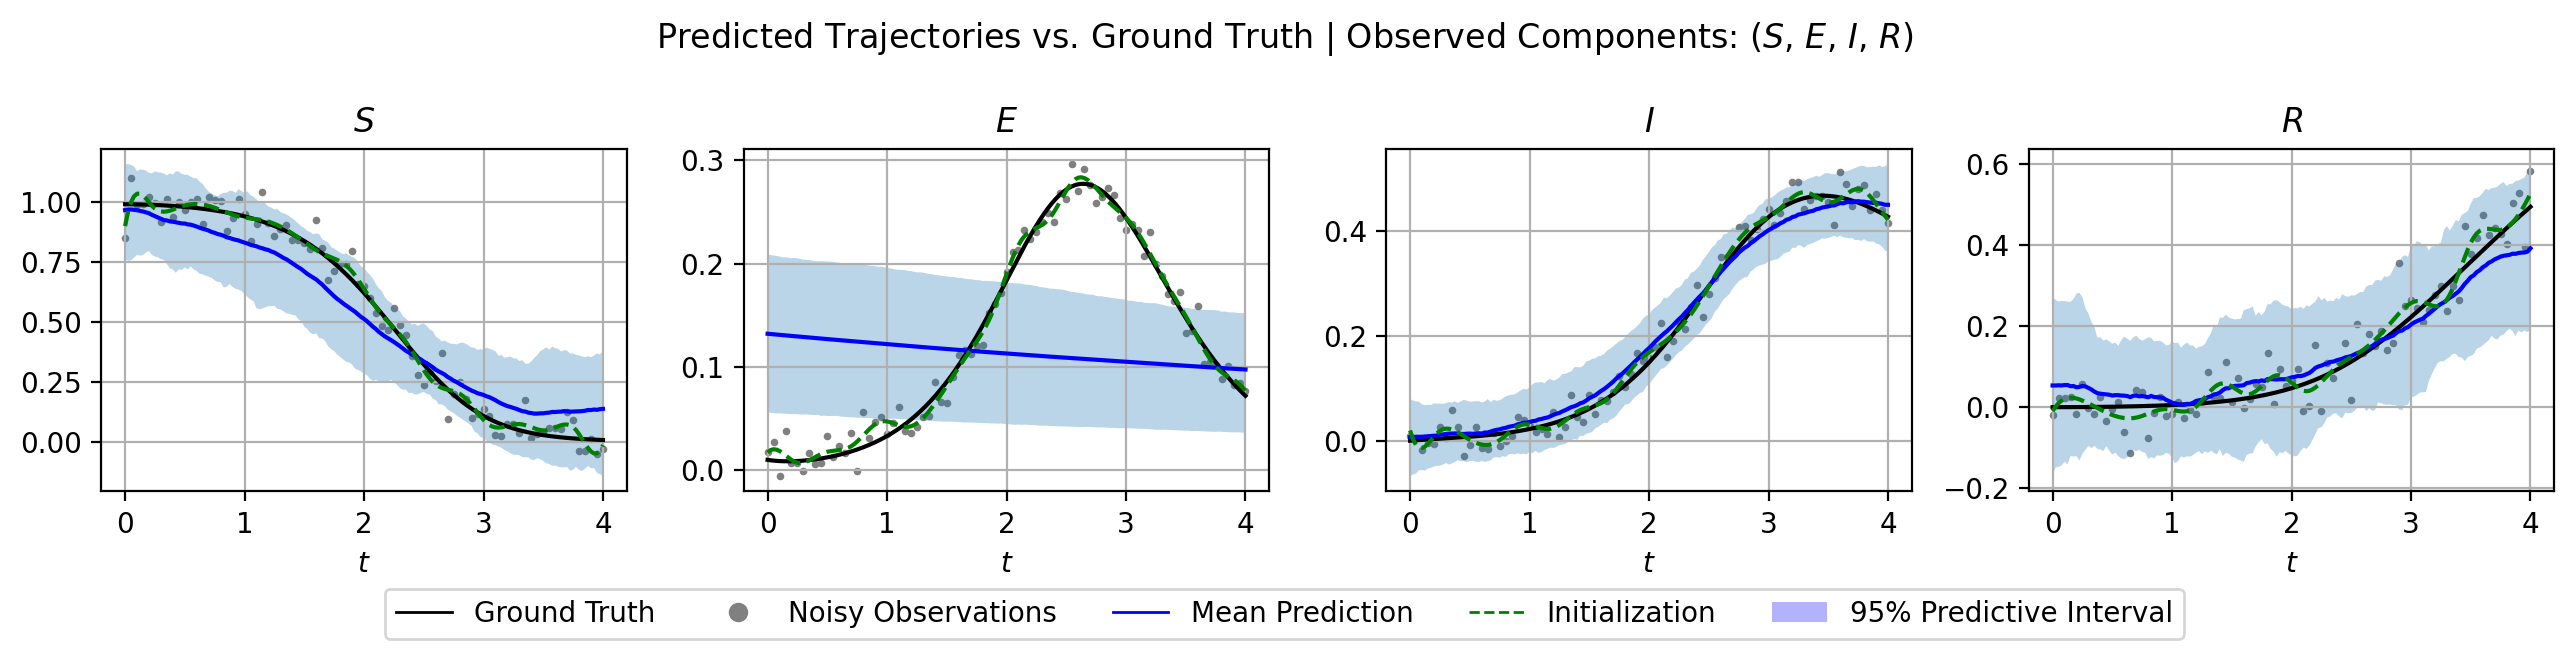

In [5]:
# visualize our trajectories
fig, ax = plt.subplots(1, 4, dpi=200, figsize=(13, 3))

# get our timesteps, mean trajectory predictions, and 2.5% + 97.5% trajectory predictions
I = results["I"].flatten()
Xhat_means = results["X_samps"].mean(axis=0)
Xhat_intervals = np.quantile(results["X_samps"], q=[0.025, 0.975], axis=0)
Xhat_init = results["Xhat_init"]

# go through each component and plot
for i, comp in enumerate(["$S$", "$E$", "$I$", "$R$"]):
    
    # plot the ground truth + noisy observations
    if comp_obs[i]:
        ax[i].scatter(ts_obs, X_obs[:,i], s=3, color="grey")
    ax[i].plot(raw_data["t"], raw_data[["S_true", "E_true", "I_true", "R_true"][i]], color="black")
    
    # plot mean trajectory + 95% predictive interval
    ax[i].plot(I, Xhat_means[:,i], color="blue")
    ax[i].fill_between(I, Xhat_intervals[0,:,i], Xhat_intervals[1,:,i], alpha=0.3)
    ax[i].plot(I, Xhat_init[:,i], linestyle="--", color="green")
    ax[i].set_title(comp); ax[i].set_xlabel("$t$")
    ax[i].grid()
    
# shared legend + beautify
observed_components_desc = str(tuple(np.array(["$S$", "$E$", "$I$", "$R$"])[comp_obs])).replace("'", "").strip()
plt.suptitle(f"Predicted Trajectories vs. Ground Truth | Observed Components: {observed_components_desc}")
custom_lines = [Line2D([0], [0], color="black", linewidth=1.0, alpha=1.0, label="Ground Truth"),
                Line2D([0], [0], color="grey", marker="o", linestyle="None", label="Noisy Observations"),
                Line2D([0], [0], color="blue", linewidth=1.0, alpha=1.0, label="Mean Prediction"),
                Line2D([0], [0], color="green", linestyle="--", linewidth=1.0, alpha=1.0, label="Initialization"),
                Patch(facecolor="blue", alpha=0.3, label="95% Predictive Interval")]
fig.legend(handles=custom_lines, loc="lower center", ncol=5, fontsize=10, bbox_to_anchor=(0.5, -0.075))
plt.tight_layout()
plt.show()

In [6]:
# check our parameters too
mean_thetas_pred = results["thetas_samps"].mean(axis=0)

print("Estimated Parameters:")
print(f"- Beta: {np.round(mean_thetas_pred[0], 3)} (Predicted) vs. 6.0 (Actual).")
print(f"- Gamma: {np.round(mean_thetas_pred[1], 3)} (Predicted) vs. 0.6 (Actual).")
print(f"- Sigma: {np.round(mean_thetas_pred[2], 3)} (Predicted) vs. 1.8 (Actual).")

Estimated Parameters:
- Beta: 0.001 (Predicted) vs. 6.0 (Actual).
- Gamma: 0.007 (Predicted) vs. 0.6 (Actual).
- Sigma: 0.077 (Predicted) vs. 1.8 (Actual).


In [7]:
# checking derivatives (i.e., physics fidelity)
raw_data["t"] = np.round(raw_data["t"].values, 3)
raw_data.set_index("t", inplace=True)

# get our true values
X_true = raw_data.loc[np.round(I, 3)][["S_true", "E_true", "I_true", "R_true"]].values
thetas_true = np.array([6.0, 0.6, 1.8])

# compute GP-implied derivatives at truth
X_cent = tf.reshape(X_true - model.mu_ds, shape=(X_true.shape[0], 1, X_true.shape[1]))
f_gp = model.m_ds @ tf.transpose(X_cent, perm=[2, 0, 1])

# compute the true derivatives at truth
f_ode = tf.transpose(f_vec(I, X_true, thetas_true)[:,None], perm=[2, 0, 1])

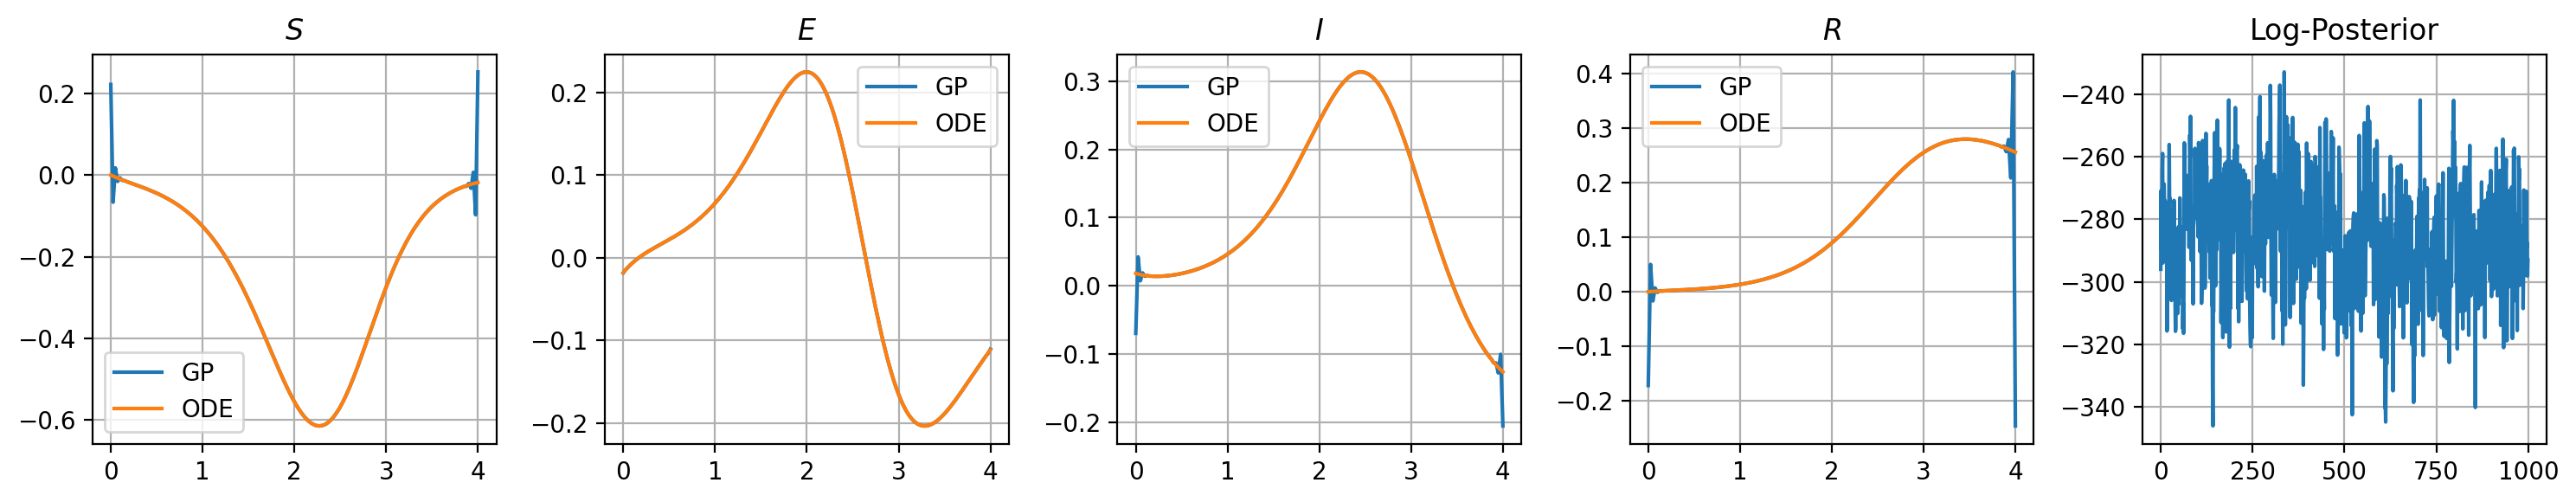

In [8]:
# checking whether the derivatives match
fig, ax = plt.subplots(1, 5, dpi=200, figsize=(15, 3))

# plot the ODE vs. GP-implied derivatives for each component
for i, comp in enumerate(["$S$", "$E$", "$I$", "$R$"]):
    
    ax[i].set_title(comp)
    ax[i].plot(I, f_gp[i], label="GP")
    ax[i].plot(I, f_ode[i], label="ODE")
    ax[i].grid(); ax[i].legend()
    
# also check the log-posterior
ax[4].set_title("Log-Posterior")
ax[4].plot(results["kernel_results"].inner_results.target_log_prob)
ax[4].grid()
    
# beautify
plt.tight_layout()
plt.show()